In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

from dataset import Dataset
from tools import getDataset, print_class_distribution

import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda:0


In [3]:
batch_size = 128
num_workers = 4
learning_rate = 0.0001 
num_epochs = 15
image_size = 84
num_classes = 50

root_dir = os.path.join(os.getcwd(), 'datasets/miniImageNet')
dataset, label_mapping = getDataset(path=root_dir, num_classes=num_classes)


train_transforms = transforms.Compose(
        [
            transforms.RandomCrop(84, padding=8),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
            transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=5),
            transforms.ToTensor(),
            transforms.Normalize((0.45, 0.45, 0.45), (0.6, 0.6, 0.6)),
        ]
    )

transforms = transforms.Compose(
        [
            transforms.RandomCrop(84, padding=8),
            transforms.ToTensor(),
            transforms.Normalize((0.45, 0.45, 0.45), (0.6, 0.6, 0.6)),
        ]
    )
       
train_dataset, temp_dataset = train_test_split(dataset, test_size=0.3, random_state=42)
val_dataset, test_dataset = train_test_split(temp_dataset, test_size=0.5, random_state=42)
      
train_dataset = Dataset(dataset=train_dataset, path=root_dir, phase='train', transform=train_transforms)
val_dataset = Dataset(dataset=val_dataset, path=root_dir, phase='val', transform=transforms)
test_dataset = Dataset(dataset=test_dataset, path=root_dir, phase='test', transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [4]:
def eval(net, data_loader, criterion=nn.CrossEntropyLoss()):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    loss = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        outs = net(images)
        loss += criterion(outs, labels).item()
        _, predicted = torch.max(outs.data, 1)
        correct += (predicted == labels).sum().item()
        num_images += len(labels)
        print('testing/evaluating -> batch: %d correct: %d numb images: %d' % (i_batch, correct, num_images) + '\r', end='')
    acc = correct / num_images
    loss /= len(data_loader)
    return acc, loss


# training function
def train(net, train_loader, valid_loader):

    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.SGD(params= net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001, betas=(0.5, 0.999))
    scheduler = StepLR(optimizer, step_size=7, gamma=0.01)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()

    training_losses = []
    training_losses_epoch = []
    val_losses = []
    for epoch in range(num_epochs):
        net.train()
        correct = 0.0  # used to accumulate number of correctly recognized images
        num_images = 0.0  # used to accumulate number of images
        total_loss = 0.0

        for i_batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            output_train = net(images)
            loss = criterion(output_train, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicts = output_train.argmax(dim=1)
            correct += predicts.eq(labels).sum().item()
            num_images += len(labels)
            total_loss += loss.item()
            training_losses.append(loss.item())

            print('training -> epoch: %d, batch: %d, loss: %f' % (epoch, i_batch, loss.item()) + '\r', end='')

        print()
        acc = correct / num_images
        acc_eval, val_loss = eval(net, valid_loader)
        average_loss = total_loss / len(train_loader)
        val_losses.append(val_loss)
        training_losses_epoch.append(average_loss)
        print('\nepoch: %d, lr: %f, accuracy: %f, avg. loss: %f, valid accuracy: %f valid loss: %f\n' % (epoch, optimizer.param_groups[0]['lr'], acc, average_loss, acc_eval, val_loss))

        scheduler.step()

    return net, training_losses, training_losses_epoch, val_losses

In [5]:
from models.resnet18 import ResNet18

print(f"Hyperparameters:")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"Number of Epochs: {num_epochs}")
print(f"Number of Workers: {num_workers}")
print(f"Number of Classes: {num_classes}\n")

# print_class_distribution(train_dataset, "Training", label_mapping)
# print_class_distribution(val_dataset, "Validation", label_mapping)
# print_class_distribution(test_dataset, "Testing", label_mapping)

model = ResNet18(num_classes=num_classes).to(device)

for param in model.parameters():
    param.requires_grad = True
    
model, training_losses, training_losses_epoch, val_losses = train(net=model, train_loader=train_loader, valid_loader=validation_loader)

acc_test, test_loss = eval(model, test_loader)
print('\naccuracy on testing data: %f' % acc_test)

Hyperparameters:
Batch Size: 128
Learning Rate: 0.0001
Number of Epochs: 15
Number of Workers: 4
Number of Classes: 50

training -> epoch: 0, batch: 164, loss: 2.339178
testing/evaluating -> batch: 35 correct: 3021 numb images: 4500
epoch: 0, lr: 0.000100, accuracy: 0.476619, avg. loss: 2.101034, valid accuracy: 0.671333 valid loss: 1.220957

training -> epoch: 1, batch: 164, loss: 2.055803
testing/evaluating -> batch: 35 correct: 3174 numb images: 4500
epoch: 1, lr: 0.000100, accuracy: 0.694619, avg. loss: 1.114135, valid accuracy: 0.705333 valid loss: 1.059117

training -> epoch: 2, batch: 164, loss: 2.245044
testing/evaluating -> batch: 35 correct: 3257 numb images: 4500
epoch: 2, lr: 0.000100, accuracy: 0.748476, avg. loss: 0.898380, valid accuracy: 0.723778 valid loss: 0.972619

training -> epoch: 3, batch: 164, loss: 0.859416
testing/evaluating -> batch: 35 correct: 3324 numb images: 4500
epoch: 3, lr: 0.000100, accuracy: 0.789571, avg. loss: 0.730515, valid accuracy: 0.738667 va

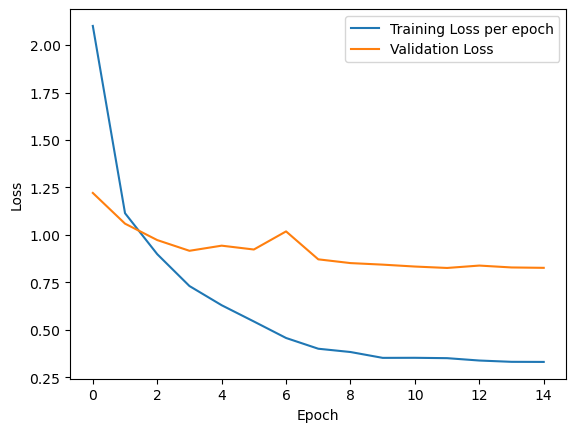

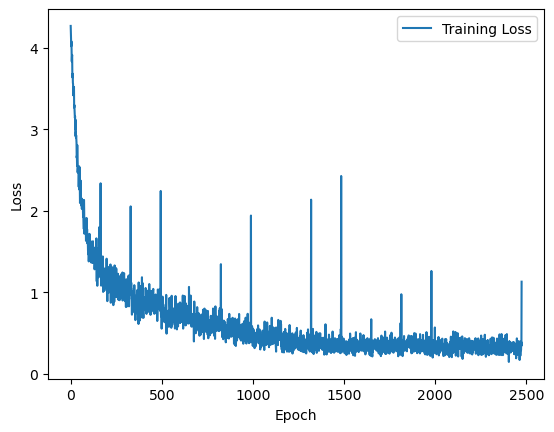

In [6]:
plt.plot(training_losses_epoch, label='Training Loss per epoch')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [7]:
torch.save(model.state_dict(), os.path.join(os.getcwd(), f'pretrained/resnet_model_best_{round(acc_test*100, 2)}.pth'))

In [8]:
model.eval()  

for i_batch, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    outs = model(images)
    _, predicted = torch.max(outs.data, 1)
    print(predicted)
    print(labels)
    _, predicted = torch.max(outs.data, 1)
    correct = (predicted == labels).sum().item()
    print(correct, len(labels), correct/len(labels))
    break

tensor([ 9, 32, 22,  0, 33,  9, 49, 39, 38, 41,  1, 21,  1, 21, 30, 31, 30, 46,
         1, 29, 26, 45, 20,  8, 15, 28, 22, 21, 14, 33, 42, 38, 41, 22, 32, 27,
        14,  8, 29, 49, 20, 29, 27,  4, 36, 38,  9,  9, 14, 24, 44, 26, 39, 20,
        29, 20, 17,  0, 45, 45, 49, 40,  3, 27, 23,  1, 24,  4, 36, 27,  4, 37,
        35,  4, 34, 25, 17,  9, 27,  8, 45,  1, 15, 48,  5, 26, 43, 19,  3, 35,
         7, 40, 12, 42, 27, 19, 47,  5, 37, 32, 39, 10,  0, 45, 33, 10, 46,  4,
        31,  1, 49,  4, 32, 38, 49, 41, 29, 27, 36, 20, 35,  9, 35,  4, 14, 13,
        49, 25], device='cuda:0')
tensor([ 9, 32, 22, 17, 33,  9, 49, 39, 13, 41,  1, 21,  1, 21, 30,  6, 30, 46,
         1, 29, 26, 11,  5,  8, 33, 28, 22, 21, 24, 33, 49,  1, 41, 22, 14, 27,
        24, 39, 24, 49, 20, 29, 27,  4, 36, 38, 28,  9, 14, 24, 44, 26, 39, 20,
        29, 20, 17,  1, 23, 45, 49, 40,  3, 14, 23, 19, 24,  4, 36, 27,  4, 37,
        28,  4, 34, 13, 12,  9, 27,  8, 45,  1, 15, 24,  5, 26, 43, 19,  3,  0,
      

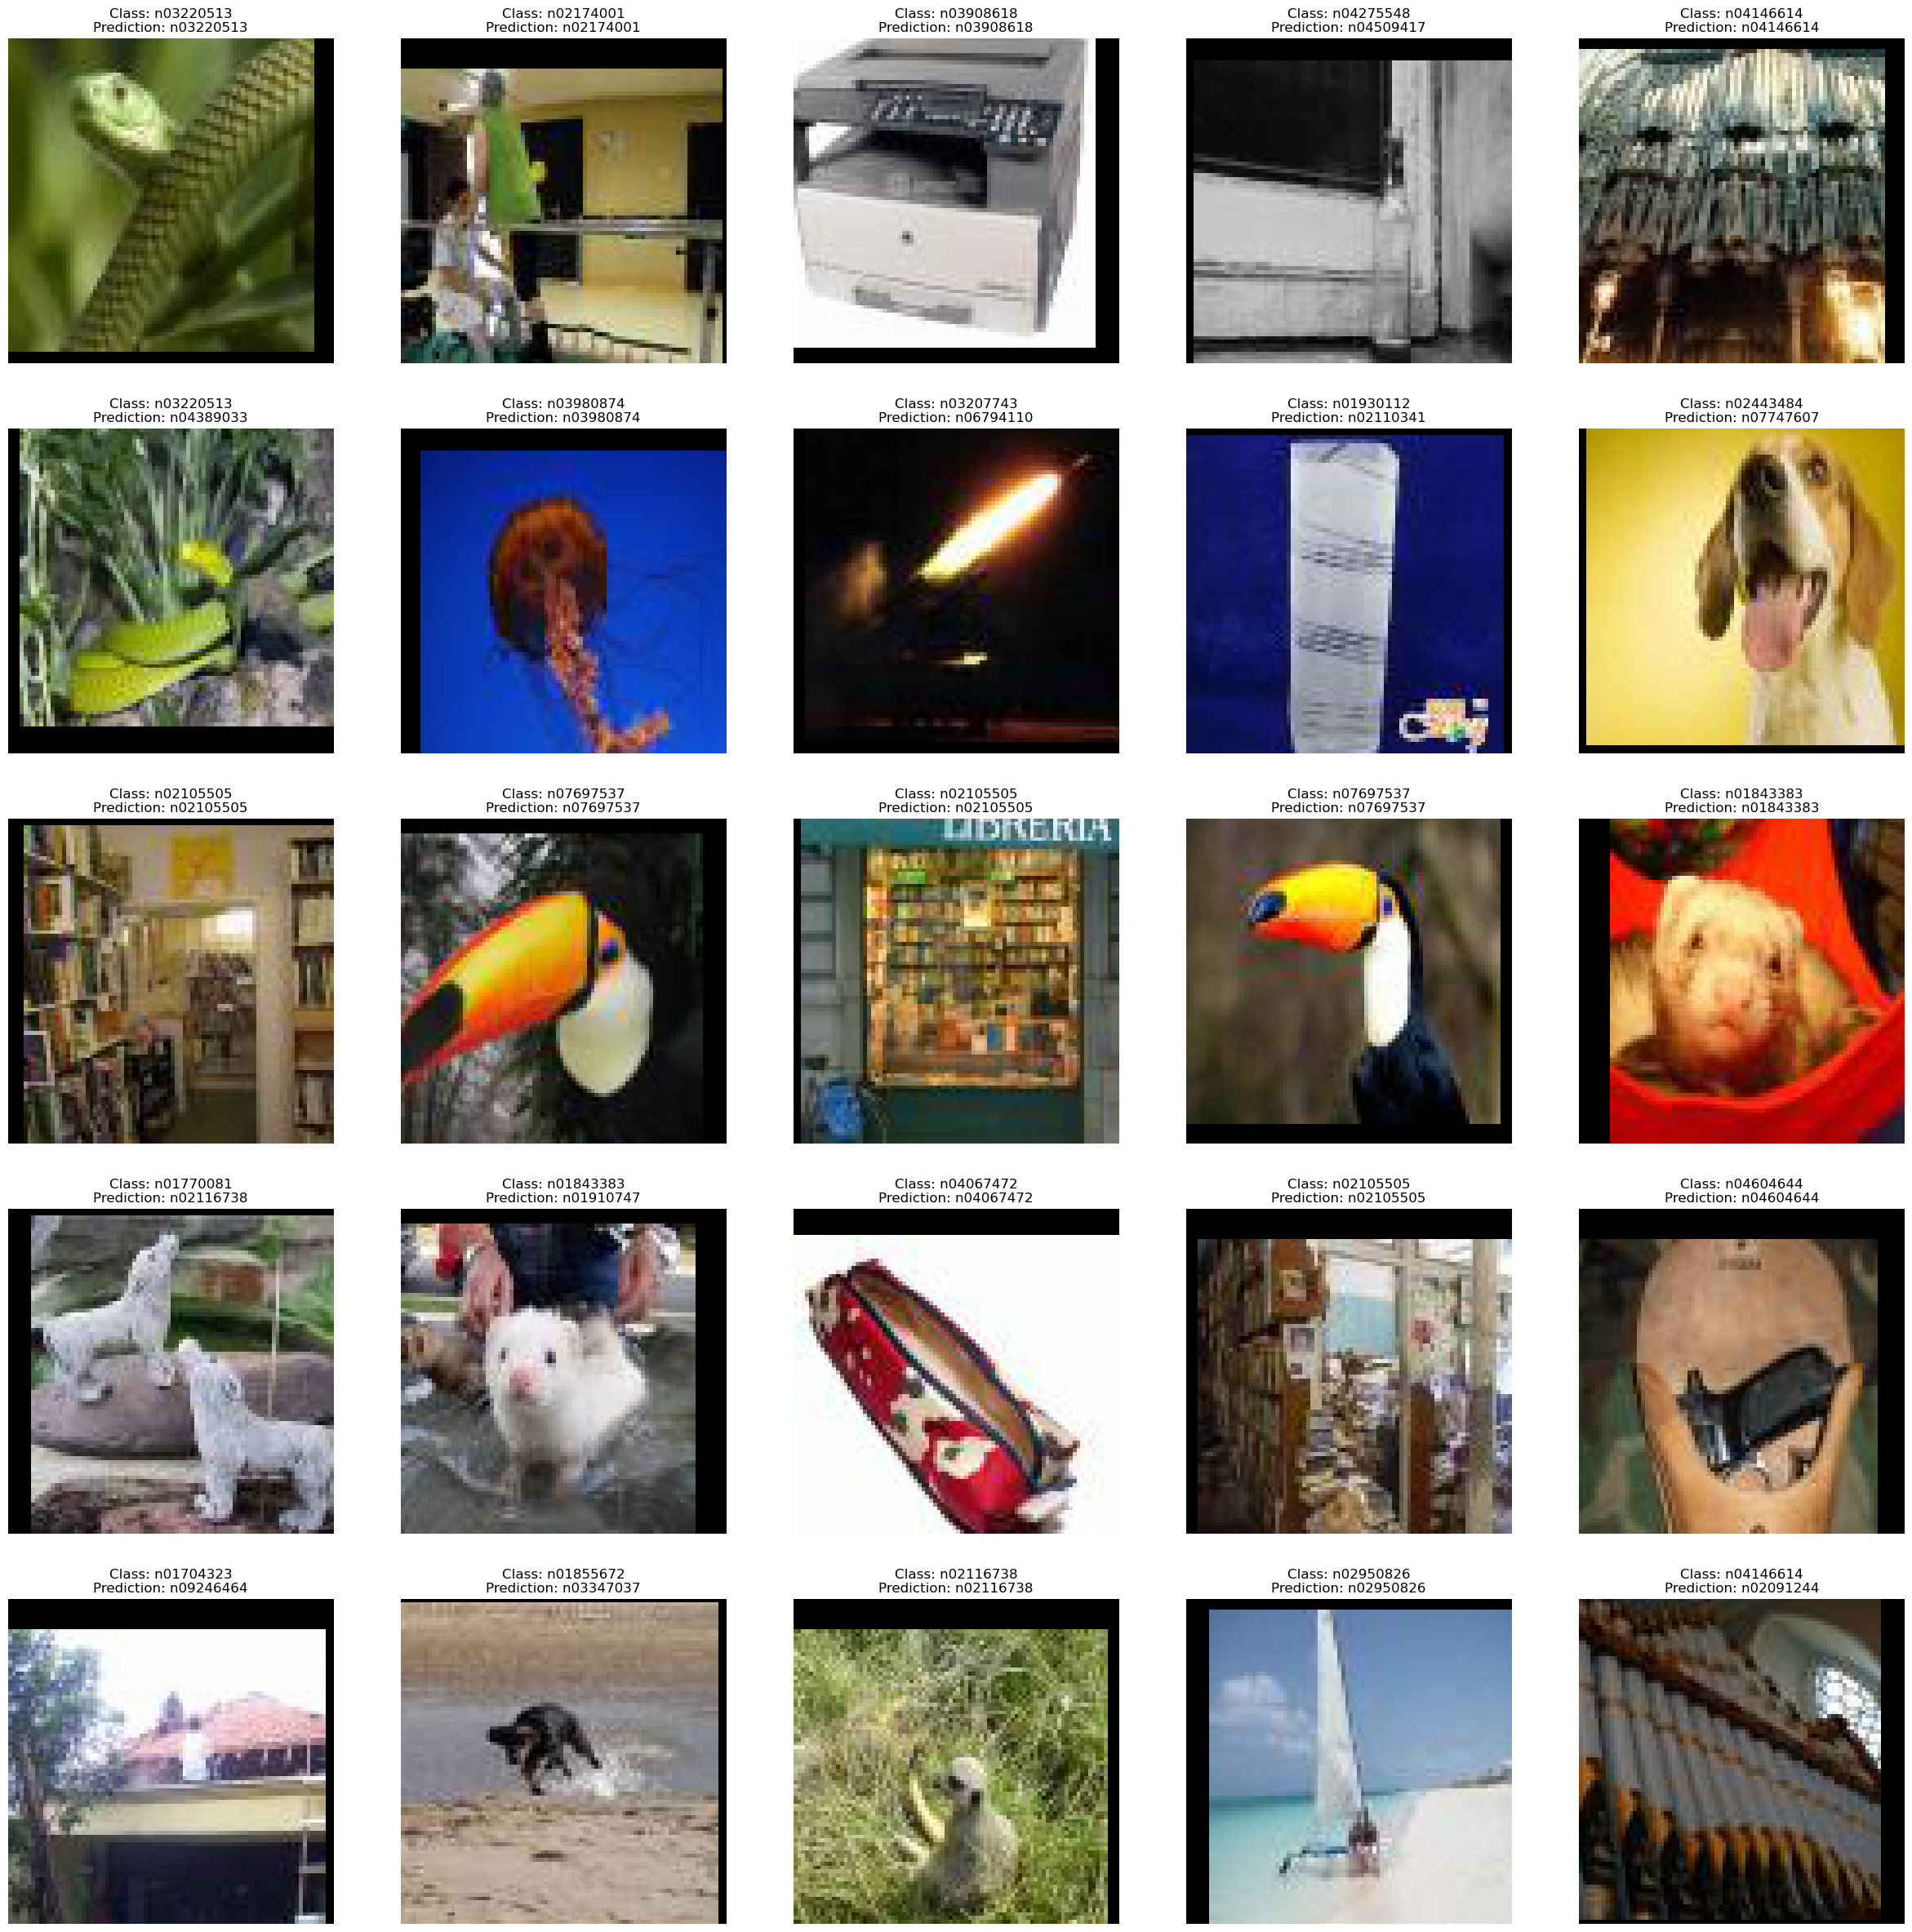

In [9]:
from torchvision import transforms, datasets

root_dir = os.path.join(os.getcwd(), 'datasets/miniImageNet')
dataset, label_mapping = getDataset(path=root_dir, num_classes=num_classes, shuffle_images=False)

transforms = transforms.Compose(
            [
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.45, 0.45, 0.45), (0.6, 0.6, 0.6)),
            ]
        )
        
dataset = Dataset(dataset=dataset, path=root_dir, transform=transforms)
loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=num_workers)

model.eval()
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()
        
fig, axs = plt.subplots(5, 5, figsize=(30, 30))  # Adjust figsize as needed

for i_batch, (images, labels) in enumerate(loader):
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outs = model(images)
        _, predict = torch.max(outs.data, 1)
        
        correct = (predict == labels).sum().item()
        
        ax = axs[int(i_batch/5), i_batch%5]
        ax.set_title('Class: {}\nPrediction: {}'.format(label_mapping[labels[0].item()],
                                                        label_mapping[predict[0].item()]))
        ax.axis('off')

        # Revert normalization
        images_display = images[0].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.45, 0.45, 0.45])
        std = np.array([0.6, 0.6, 0.6])
        images_display = std * images_display + mean
        images_display = np.clip(images_display, 0, 1) 

        ax.imshow(images_display)  # Assuming images are in CHW format
        
        if(i_batch >= 24):
            break